# Assignment 1: Dataset Exploration and A Study of the k-Nearest Neighbors Model

Task/Problem Statement: 
- Briefly describe your project/task/problem

### Dataset
- Provide information about the dataset



##### Description: 

###### Source:
- It could be a URL



##### Input variables:
- Provide a list

##### Output variable: 
- 




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

## Load Data & Display Dataset Information

In [2]:
# Load the excel file as a Pandas DataFrame object. Name it "df".
# Display the first 5 rows of the DataFrame.
df = None
try:
    df = pd.read_csv("adult.csv")
except FileNotFoundError:
    try:
        df = pd.read_excel("adult.xlsx", sheet_name="in")
    except FileNotFoundError:
        print("adult.xlsx or adult.csv not found")
        exit(1)

print(df.head(5))

    age          workclass  fnlwgt   education  education-num  \
0   NaN          State-gov   77516   Bachelors             13   
1  50.0   Self-emp-not-inc   83311   Bachelors             13   
2  38.0            Private  215646     HS-grad              9   
3  53.0            Private  234721        11th              7   
4  28.0            Private  338409   Bachelors             13   

        marital-status          occupation     relatioship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States 

In [3]:
# Display a summary of the dataset information.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32560 non-null  float64
 1   workclass       32561 non-null  object 
 2   fnlwgt          32561 non-null  int64  
 3   education       32561 non-null  object 
 4   education-num   32561 non-null  int64  
 5   marital-status  32561 non-null  object 
 6   occupation      32561 non-null  object 
 7   relatioship     32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  int64  
 11  capital-loss    32561 non-null  int64  
 12  hours-per-week  32561 non-null  int64  
 13  native-country  32561 non-null  object 
 14  income          32561 non-null  object 
dtypes: float64(1), int64(5), object(9)
memory usage: 3.7+ MB


In [4]:
# Display the number of categories and the list of categories for each categorical variable. For 
# example, for the categorical variable ‘sex’, display its two categories: ‘Male’ and ‘Female’
category_df = df.select_dtypes(include='object')

def print_categories(columns):
    for column in columns:
        print(f'{column} ({df[column].nunique()}): {df[column].unique()}')
        
print_categories(category_df.columns)

workclass (9): [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
education (16): [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
marital-status (7): [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation (15): [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
relatioship (6): [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
race (5): [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
sex (2): [' Male' ' Female']
native-country (42): [' Un

## Data Pre-processing


In [5]:
# Some columns may contain “?” values. Programmatically replace these "?" values with NaN values.
# strip() is used to remove leading and trailing whitespaces.
category_df = category_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
category_df = category_df.replace('?', None)

missing_values = category_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

In [6]:
# Impute the missing values with the mode value for categorical variables.
for column in missing_values.index:
    mode = category_df[column].mode()[0]
    category_df[column] = category_df[column].fillna(mode)
    print(f'Feature ({column}): {missing_values[column]} missing values. Imputed with ({mode}).')

Feature (workclass): 1836 missing values. Imputed with (Private).
Feature (occupation): 1843 missing values. Imputed with (Prof-specialty).
Feature (native-country): 583 missing values. Imputed with (United-States).


In [7]:
# One-hot encode the categorical features and combine the one-hot encoded features with the non-
# categorical columns. Ensure that only (n-1) columns are added for a categorical variable with n 
# categories. The DataFrame object “df” should include all one-hot encoded and non-categorical 
# features. Finally, display the first five rows of the modified “df
onehot_df = pd.get_dummies(category_df, drop_first=True).astype(int)
df = df.drop(columns=category_df.columns)
df = pd.concat([df, onehot_df], axis=1)
print(df.head(5))

    age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   NaN   77516             13          2174             0              40   
1  50.0   83311             13             0             0              13   
2  38.0  215646              9             0             0              40   
3  53.0  234721              7             0             0              40   
4  28.0  338409             13             0             0              40   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0                    0                       0                  0   
1                    0                       0                  0   
2                    0                       0                  1   
3                    0                       0                  1   
4                    0                       0                  1   

   workclass_Self-emp-inc  ...  native-country_Puerto-Rico  \
0                       0  ...                        

In [8]:
# Display a list of the feature names along with their indices. 
# For example, the first feature (index 0) is “age”.
print("Index: Feature Name")
for i, column in enumerate(df.columns):
    print(f'{i}: {column}')

Index: Feature Name
0: age
1: fnlwgt
2: education-num
3: capital-gain
4: capital-loss
5: hours-per-week
6: workclass_Local-gov
7: workclass_Never-worked
8: workclass_Private
9: workclass_Self-emp-inc
10: workclass_Self-emp-not-inc
11: workclass_State-gov
12: workclass_Without-pay
13: education_11th
14: education_12th
15: education_1st-4th
16: education_5th-6th
17: education_7th-8th
18: education_9th
19: education_Assoc-acdm
20: education_Assoc-voc
21: education_Bachelors
22: education_Doctorate
23: education_HS-grad
24: education_Masters
25: education_Preschool
26: education_Prof-school
27: education_Some-college
28: marital-status_Married-AF-spouse
29: marital-status_Married-civ-spouse
30: marital-status_Married-spouse-absent
31: marital-status_Never-married
32: marital-status_Separated
33: marital-status_Widowed
34: occupation_Armed-Forces
35: occupation_Craft-repair
36: occupation_Exec-managerial
37: occupation_Farming-fishing
38: occupation_Handlers-cleaners
39: occupation_Machine-

0    0
1    0
2    0
3    0
4    0
Name: income_>50K, dtype: int32


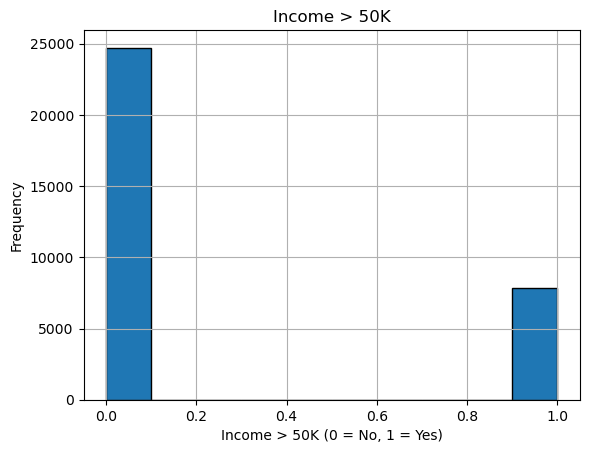

In [9]:
# Display the first five values of the binary target column (0s and 1s). Create a histogram of the
# target column (i.e., income_>50K).
print(df['income_>50K'].head(5))
df['income_>50K'].hist(edgecolor='black', rwidth=1)
plt.title('Income > 50K')
plt.xlabel('Income > 50K (0 = No, 1 = Yes)')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Identify the features (columns) with missing values in the “df”. For each feature with missing
# values, display the total count of missing values.
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
for column in missing_values.index:
    print(f'Feature ({column}): {missing_values[column]} missing values')

Feature (age): 1 missing values


In [12]:
# Replace the missing values in each feature with the median value. First, compute the median of
# each feature. Then, replace the missing values with these medians. Display the first five rows of
# the modified “df”.
for column in missing_values.index:
    median = df[column].median()
    df[column] = df[column].fillna(median)
    print(f'Feature ({column}): {missing_values[column]} missing values. Imputed with ({median}).')

print("----------------------")
print(df.head(5))

Feature (age): 1 missing values. Imputed with (37.0).
----------------------
    age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0  37.0   77516             13          2174             0              40   
1  50.0   83311             13             0             0              13   
2  38.0  215646              9             0             0              40   
3  53.0  234721              7             0             0              40   
4  28.0  338409             13             0             0              40   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0                    0                       0                  0   
1                    0                       0                  0   
2                    0                       0                  1   
3                    0                       0                  1   
4                    0                       0                  1   

   workclass_Self-emp-inc  ...  native-

## Data Analysis

In [ ]:
# Compute the Pearson correlation coefficient (also known as the standard correlation coefficient)
# between the binary target and all features. Display the complete list of correlations.
def homebrew_pearson(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    x_diff = x - x_mean
    y_diff = y - y_mean
    numerator = (x_diff * y_diff).sum()
    denominator = np.sqrt((x_diff**2).sum() * (y_diff**2).sum())
    return numerator / denominator

for column in df.columns:
    hb_correlation = homebrew_pearson(df[column], df['income_>50K'])
    correlation = df[column].corr(df['income_>50K'])
    print(f'{column}: {correlation} (Homebrew: {hb_correlation})')

## Create Data Matrix X and Target y

In [17]:
# Create a deep copy of the DataFrame object using the copy() method of DataFrame. Name it as
# “df_main”. You will need it for Experiment 5.
df_main = df.copy()

In [18]:
# From “df”, create separate DataFrame objects for the features and the target.
X = df.drop(columns='income_>50K')
y = df['income_>50K']

In [19]:
# Convert the feature and target DataFrame objects into NumPy arrays (X for the feature matrix and
# Y for the target matrix).
X = X.to_numpy()
y = y.to_numpy()

In [20]:
# Display the shape and data type of the feature and target arrays.
print(f'X: {X.shape}, {X.dtype}')
print(f'y: {y.shape}, {y.dtype}')

X: (32561, 97), float64
y: (32561,), int32


[0 1] [24720  7841]


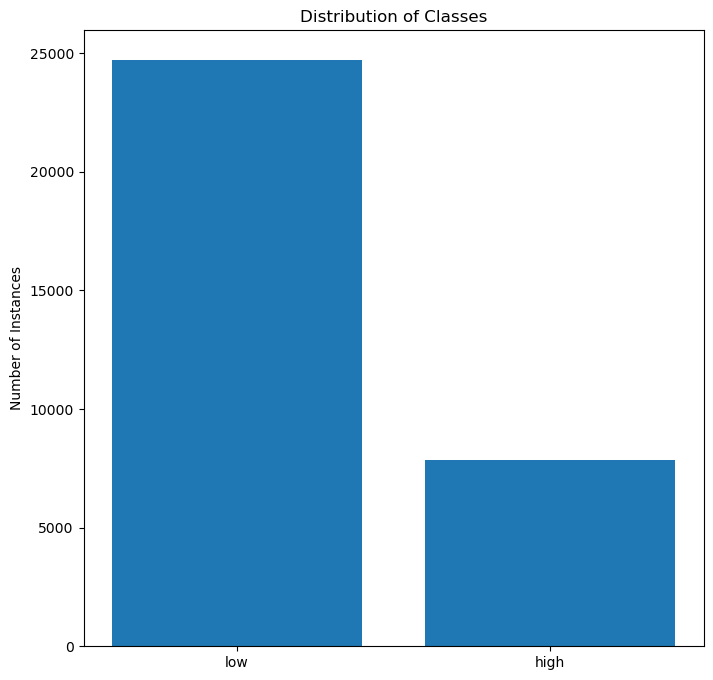

In [32]:
# Create a bar plot for the new target array to show the distribution of samples in the two classes.
# You must use NumPy arrays to create the plot and are not allowed to use DataFrame methods.
# Label the vertical axis as “Number of Instances”. Display the class labels (“high” or “low”) at
# the bottom of each bar on the horizontal axis. The title of the figure should be “Distribution of
# Classes”, and the figure dimensions should be (8, 8).
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
plt.figure(figsize=(8, 8))
plt.bar(['low', 'high'], counts)
plt.ylabel('Number of Instances')
plt.title('Distribution of Classes')
plt.show()

## Partition the Dataset into Train & Test Subsets

In [33]:
# Partition the dataset into training & test subsets: 80% training & 20% test (you may use
# Scikit-Learn’s train_test_split() function)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardize the Data

## Model Selection

In [ ]:
%%time



## Train a Model Using Optimal Hyperparameters

In [ ]:
%%time

## Evaluate the Model 

In [ ]:
%%time

